In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

In [0]:
%run Accuracy_Module.py
%run DataLoading.py
%run load_and_organize_dataset.py

In [0]:
in_path = 'UTKFace/'
out_path = 'Data/'

count = organize_files(in_path, out_path)

In [0]:
train_data, valid_data, test_data = load_dataset(256)

531


In [18]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 19.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [21]:
fileId = drive.CreateFile({'id': '0BxYys69jI14kYVM3aVhKS1VhRUk'}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  # folder_data.zip
fileId.GetContentFile('UTKFace.tar.gz')  # Save Drive file as a local file

UTKFace.tar.gz


In [22]:
!apt-get install p7zip-full
!p7zip -d UTKFace.tar.gz
!tar -xvf UTKFace.tar.gz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
/usr/bin/p7zip: UTKFace.tar.gz: unknown suffix
UTKFace/82_0_2_20170111210110290.jpg.chip.jpg
UTKFace/32_1_2_20170116180211518.jpg.chip.jpg
UTKFace/21_0_4_20170103225103768.jpg.chip.jpg
UTKFace/27_1_2_20170116171716287.jpg.chip.jpg
UTKFace/26_0_4_20170117153355923.jpg.chip.jpg
UTKFace/26_1_0_20170116231512359.jpg.chip.jpg
UTKFace/54_0_3_20170119211308521.jpg.chip.jpg
UTKFace/25_1_1_20170112235005249.jpg.chip.jpg
UTKFace/4_1_2_20161219211452533.jpg.chip.jpg
UTKFace/16_0_0_20170110232647979.jpg.chip.jpg
UTKFace/26_1_0_20170119192623081.jpg.chip.jpg
UTKFace/26_1_1_20170116170028717.jpg.chip.jpg
UTKFace/26_1_2_20170116180214166.jpg.chip.jpg
UTKF

In [0]:
drive = "/content/UTKFace/"
import os

i=0
for i in range(1,117):
  # define the name of the directory to be created
  path = drive + "{}".format(i)

  try:  
      os.mkdir(path)
  except OSError:  
      print ("Creation of the directory %s failed" % path)
  else:  
      print ("Successfully created the directory %s " % path)

In [0]:
import shutil
k=0
for root, dirs, files in os.walk(drive): 
   for file in files:
      path_file = os.path.join(root,file)
      age = file.split("_")[0]
      destination = drive + str(age) + "/" + file
      if(file.endswith("jpg")):
        shutil.move(path_file, destination)
        k+=1
        if k%100==0:
          print ("Copying {} to age folder {}".format(file, destination))

In [0]:
def load_dataset(batch_size):
    np.random.seed(1000)
    
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    train_dataset = CustomImageFolder(root='./Data/train', transform=transform)
    val_dataset = CustomImageFolder(root='./Data/valid', transform=transform)
    test_dataset = CustomImageFolder(root='./Data/test', transform=transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                              num_workers=0, shuffle=True)

    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                              num_workers=0, shuffle=True)

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                             num_workers=0, shuffle=True)
    
    return train_loader, val_loader, test_loader

In [0]:
def organize_files(in_path, out_path):
    '''Function to split the samples into training, validation and test folders'''
    files = os.listdir(in_path)
    
    count_dict = {}
    for f in files:
        labels = f.split('_')[:3]
        name = '_'.join(labels)
        
        if name in count_dict:
            count_dict[name] += 1
        else:
            count_dict[name] = 1    
    
    # Making folders for each dataset
    for dirs in ['train', 'valid', 'test']:
        os.makedirs(out_path + dirs, exist_ok=True)
        for i in range(1, 117):
            os.makedirs(out_path + dirs + '/' + str(i), exist_ok=True)
    
    for label in count_dict:
        fs = list(filter(lambda x: '_'.join(x.split('_')[:3]) == label, files))
        train_count = len(fs)*0.7
        valid_count = len(fs)*0.85
        train_copied = 0
        valid_copied = 0
        
        for f in fs:
            age = f.split('_')[0]
            
            if (train_copied < train_count):
                shutil.copy(in_path + f, out_path + 'train/' + age + '/' + f)
                train_copied += 1
            elif (valid_copied < valid_count - train_count):
                shutil.copy(in_path + f, out_path + 'valid/' + age + '/' + f)
                valid_copied += 1
            else:
                shutil.copy(in_path + f, out_path + 'test/' + age + '/' + f)
  
    return count_dict

In [0]:
in_path = 'UTKFace/'
out_path = 'Data/'

count = organize_files(in_path, out_path)

In [0]:
def get_data_loader(batch_size):
    classes = range(1, 117)
    classes = [str(x) for x in classes]
    
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    # Training set
    train_set = torchvision.datasets.ImageFolder('Data/train', transform = transform)
    '''
    relevant_train_indices = get_relevant_indices(
            train_set,
            classes,
            target_classes)
    '''
    #indices = torch.randperm(len(train_set))
    #train_sampler = SubsetRandomSampler(indices)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                              num_workers=1, shuffle = True)
    
    
    
    # Validation set
    val_set = torchvision.datasets.ImageFolder('Data/valid', transform = transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                              num_workers=1, shuffle = True)
    # Test set
    test_set =  torchvision.datasets.ImageFolder('Data/test', transform = transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers=1, shuffle = True)

    return train_loader, val_loader, test_loader

89


In [0]:
train_loader, val_loader, test_loader = get_data_loader(batch_size = 32)

torch.Size([3, 200, 200])


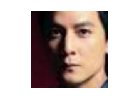

tensor(29)
torch.Size([3, 200, 200])


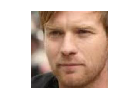

tensor(29)
torch.Size([3, 200, 200])


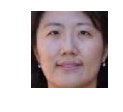

tensor(37)
torch.Size([3, 200, 200])


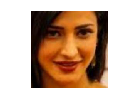

tensor(34)
torch.Size([3, 200, 200])


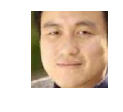

tensor(39)
torch.Size([3, 200, 200])


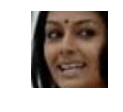

tensor(35)
torch.Size([3, 200, 200])


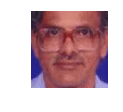

tensor(57)
torch.Size([3, 200, 200])


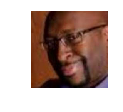

tensor(43)
torch.Size([3, 200, 200])


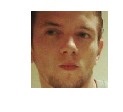

tensor(21)
torch.Size([3, 200, 200])


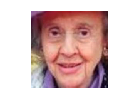

tensor(60)
torch.Size([3, 200, 200])


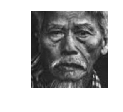

tensor(64)
torch.Size([3, 200, 200])


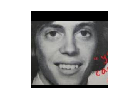

tensor(25)
torch.Size([3, 200, 200])


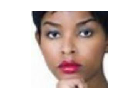

tensor(28)
torch.Size([3, 200, 200])


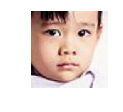

tensor(6)
torch.Size([3, 200, 200])


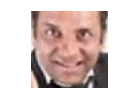

tensor(48)


In [28]:
k = 0
for images, labels in train_data:
    img = images[0]
    print(img.shape)
    img = np.transpose(img, [1,2,0])
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    print(labels[0])
    k += 1
    if k > 14:
        break

In [0]:
train_loader, valid_loader = load_dataset(32)

FileNotFoundError: ignored

In [0]:
class VGGfeature(nn.Module):
  
  
  def load_weights(self):
      pre_trained=torch.load("/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Parameters/vgg_face_dag.pth")
      new=list(pre_trained.items())
      feature_key=self.state_dict()
      count=0
      for key,value in feature_key.items():
        layer_name,weights=new[count]
        feature_key[key]=weights
        count+=1

      self.load_state_dict(feature_key)
  
  
  def __init__(self):
    super(VGGfeature, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding = 0),
        nn.Conv2d(64, 128, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(128, 128, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding = 0),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(256, 256, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding = 0),
        nn.Conv2d(256, 512, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding = 0),
        nn.Conv2d(512, 512, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.Conv2d(512, 512, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(kernel_size=2, stride=2, padding = 0)
    )
    
    self.load_weights()
    
    
  def forward(self, x):
      x = self.features(x)
      return x

    

In [0]:
# Importing relevant Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import os
import torchvision
import matplotlib.pyplot as plt

from torchvision import datasets, models, transforms
from torch.nn import functional as F
import copy
from torch.autograd import Variable


###############################################################################
# Feature Extraction using AlexNet pretrained model

class AlexNetFeatures(nn.Module):
    '''
    Class that loads AlexNet Feature Model ('Convolution layers') with imagenet trained weights
    
    input : image tensors with dimension Lx3x224x224
    
    output : feature tensor with dimension Lx256x6x6
    
    *L - Batch size
    
    '''
    
    def load_weights(self):
        an_builtin = torchvision.models.alexnet(pretrained=True) # Loads the pretrained model weights
        
        features_weight_i = [0, 3, 6, 8, 10]
        for i in features_weight_i:
            self.features[i].weight = an_builtin.features[i].weight
            self.features[i].bias = an_builtin.features[i].bias

    def __init__(self):
        super(AlexNetFeatures, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.load_weights() # Copies the weights to AlexNetFeatures model layers

    def forward(self, x):
        x = self.features(x)
        return x


In [0]:
class classifier(nn.Module):
  def __init__(self):
    super(classifier, self).__init__()
    self.name = "classifier"
    self.classifier = nn.Sequential(
          nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(inplace=True)
          #nn.MaxPool2d(kernel_size=2, stride=1),
          )
    
    #self.fc = (3200, 1)

  def forward(self, x, batch_size):
    x = self.classifier(x)
    x = x.view(batch_size, -1)
    fc = nn.Linear(x.shape[1], 1)
    x = fc(x)
    return x

In [0]:
class regression(nn.Module):
    def __init__(self):
        super(regression, self).__init__()
        self.name = "regression"
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(6400, 6400)
        self.fc2 = nn.Linear(6400, 3200)
        self.fc3 = nn.Linear(3200, 1024)
        self.fc4 = nn.Linear(1024, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 1)
    def forward(self, x):
        x = x.cuda()
        x = alexNet.features(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        x = x.squeeze(1)
        
        return x

In [0]:
#get alexnet feature

In [0]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [0]:
def evaluate(data_eval, net, criterion, batch_size =32):
    total_epoch = 0
    total_loss = 0
    for i, data in enumerate(data_eval, 0):
        # Get the inputs
        inputs, labels = data
        # Zero the parameter gradients
        #optimizer.zero_grad()
        # Forward pass, backward pass, and optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.float().cuda())
        #loss.backward()
        #optimizer.step()
        total_loss += loss.item()
        total_epoch += len(labels)
    return float(total_loss)/(total_epoch)
  

In [0]:
def train_net(train_data, valid_data, net, batch_size=32, learning_rate=5e-05, num_epochs=3):
    
    
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    from torch.autograd import Variable
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    #train_loader, val_loader, test_loader = load_dataset(batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be 
    # Optimizer will be SGD with Momentum.
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_epoch = 0
        total_train_loss = 0
        #random.shuffle(train_data)
        for i, data in enumerate(train_data, 0):
          
            
          
            # Get the inputs
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            
            outputs = net(Variable(inputs.cuda()))
            
            loss = criterion(outputs.cuda(), labels.float().cuda())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_epoch += len(labels) #adding batch size
            
            
        # save the current training information
        train_losses.append(float(total_train_loss)/total_epoch)            # compute *average* loss
        val_losses.append(evaluate(valid_data, net, criterion, batch_size = batch_size))
        train_acc.append(get_accuracy(net, train_data)) # compute training accuracy 
        val_acc.append(get_accuracy(net, valid_data))  # compute validation accuracy
            
        print("Epoch: {}, Training Loss: {:.3f}, Validation Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Accuracy: {:.3f}".format(epoch+1, train_losses[-1], val_losses[-1], train_acc[-1],val_acc[-1]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        
    # plotting
    plt.title("Loss curves w/ lr={}, batch size = {}".format(learning_rate, batch_size))
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Acc curves w/ lr={}, batch size = {}".format(learning_rate, batch_size))
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [0]:
def train_net_modif(train_data, valid_data, net, batch_size=32, learning_rate=5e-05, num_epochs=20):
    
    
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    from torch.autograd import Variable
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    #train_loader, val_loader, test_loader = load_dataset(batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be 
    # Optimizer will be SGD with Momentum.
    criterion = nn.MSELoss()#.cuda()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-5)

    # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_epoch = 0
        total_train_loss = 0
        random.shuffle(train_data)
        for i, data in enumerate(train_data, 0):
          
            
          
            # Get the inputs
            inputs, labels = data
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            
            outputs = net(inputs)
            
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_epoch += len(labels) #adding batch size
            
            
        # save the current training information
        train_losses.append(float(total_train_loss)/total_epoch)            # compute *average* loss
        val_losses.append(evaluate(valid_data, net, criterion, batch_size = batch_size))
        train_acc.append(get_accuracy(net, train_data)) # compute training accuracy 
        val_acc.append(get_accuracy(net, valid_data))  # compute validation accuracy
            
        print("Epoch: {}, Training Loss: {:.3f}, Validation Loss: {:.3f}, Training Accuracy: {:.3f}, Validation Accuracy: {:.3f}".format(epoch+1, train_losses[-1], val_losses[-1], train_acc[-1],val_acc[-1]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        
    # plotting
    plt.title("Loss curves w/ lr={}, batch size = {}".format(learning_rate, batch_size))
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Acc curves w/ lr={}, batch size = {}".format(learning_rate, batch_size))
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

In [0]:
def get_accuracy(model, data, batch_size = 32):
    c=0
    mean = 0.0
    for imgs, labels in data:
      mean += labels.sum()
      c+=32
    mean = (mean/c)
    
    #print(mean)
    
    correct = 0
    total = 0
    count = 0 
    ss_reg = 0
    ss_total = 0
    
    for imgs, labels in data:
        labels = labels.float()
        output = model(imgs) # We don't need to run F.softmax
        # print(output)
        # pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # correct += pred.eq(labels.view_as(pred)).sum().item()
        output = torch.round(output)
        output = output.float()
        output = output.cpu().detach().numpy()
        output = torch.tensor(output)
        #correct += np.isclose(output.detach().numpy(), labels, 0.05).sum()
        total += imgs.shape[0]
        count+=1
        ss_reg += ((labels-output)**2).sum()
        ss_total += ((labels-mean)**2).sum()
    return 1-ss_reg/ss_total

In [0]:
#alexNet = AlexNetFeatures()
#vggModel = VGGfeature()
#built_in_VGG = models.vgg16()
#features = torch.load("/content/drive/My Drive/ALEX_BATCHSIZE_32_FEATURES")
#outputModel = classifier()
outputModel = regression()
outputModel = outputModel.cuda()

In [0]:
alexNet = models.alexnet(pretrained=True)

In [0]:
alexNet = alexNet.cuda()

In [43]:

for i, data in enumerate(train_data, 0):
    train_features = []
    inputs, labels = data
    train_features.append((alexNet.features(inputs), labels))
    torch.save(train_features, '/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/train/alex_train_feature_256_{}'.format(i))
    
print("train features saved")

for i, data in enumerate(valid_data, 0):
    valid_features = []
    inputs, labels = data
    valid_features.append((alexNet.features(inputs), labels))
    torch.save(train_features, '/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/valid/alex_valid_feature_256_{}'.format(i))

print("valid features saved")    
  
for i, data in enumerate(test_data, 0):
    test_features = []
    inputs, labels = data
    test_features.append((alexNet.features(inputs), labels))
    torch.save(train_features, '/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/test/alex_test_feature_256_{}'.format(i))

print("test features saved")


train features saved
valid features saved
test features saved


In [0]:
alex_train_features = []
alex_valid_features = []
alex_test_features = []
for i in range(67):
    alex_train_features.append(torch.load('/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/train/alex_train_feature_256_{}'.format(i)))
  
for i in range(15):
    alex_valid_features.append(torch.load('/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/valid/alex_valid_feature_256_{}'.format(i)))

for i in range(12):
    alex_test_features.append(torch.load('/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/test/alex_test_feature_256_{}'.format(i)))


In [0]:
alex_train_features = []
alex_valid_features = []
alex_test_features = []
for i in range(67):
    alex_train_features += torch.load('/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/train/alex_train_feature_256_{}'.format(i))
  
for i in range(15):
    alex_valid_features += torch.load('/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/valid/alex_valid_feature_256_{}'.format(i))

for i in range(12):
    alex_test_features += torch.load('/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Features/Alexnet_Features/test/alex_test_feature_256_{}'.format(i))


In [0]:
new_train_features = []

for i in range(67):
    new_train_features += alex_train_features[i] 


In [0]:
new_train_features = []
new_train_labels = []
new_valid_features = []
new_valid_labels = []
new_test_features = []
new_test_labels = []

for i in range(67):
    tr_features, tr_labels = alex_train_features[i]
    
    for j in range(len(tr_labels)):
        new_train_features.append(tr_features[j])
        new_train_labels.append(tr_labels[j])

for i in range(15):
    val_features, val_labels = alex_valid_features[i]
    
    for j in range(len(val_labels)):
        new_valid_features.append(val_features[j])
        new_valid_labels.append(val_labels[j])
    
for i in range(12):
    te_features, te_labels = alex_test_features[i]
    
    for j in range(len(te_labels)):
        new_test_features.append(te_features[j])
        new_test_labels.append(te_labels[j])

In [0]:
# Create a function called "chunks" with two arguments, l and n:
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

In [0]:
# Create a list that from the results of the function chunks:
batched_train_features = list(chunks(new_train_features, 32))
batched_train_labels = list(chunks(new_train_labels, 32))
batched_valid_features = list(chunks(new_valid_features, 32))
batched_valid_labels = list(chunks(new_valid_labels, 32))
batched_test_features = list(chunks(new_test_features, 32))
batched_test_labels = list(chunks(new_test_labels, 32))

In [277]:
print(type(batched_train_features[0][0]))
print(len(batched_train_features[0][0]))

<class 'torch.Tensor'>
256


In [246]:
type(batched_train_list[0][0][0])

list

In [0]:
batched_train_list = []
batched_valid_list = []
batched_test_list = []
for i in range(len(batched_train_labels)):
    batched_train_list.append((batched_train_features, batched_train_labels))

for i in range(len(batched_valid_labels)):
    batched_valid_list.append((batched_valid_features, batched_valid_labels))

for i in range(len(batched_test_labels)):
    batched_test_list.append((batched_test_features, batched_test_labels))

In [243]:
batched_train_list = torch.FloatTensor(batched_train_list)

ValueError: ignored

In [0]:
import torch.utils.data as data_utils

In [219]:
print(len(batched_train_list))
print(len(batched_train_list[0]))
print(len(batched_train_list[0][0]))
print(batched_train_list[0][0].shape)

531
32
2


AttributeError: ignored

In [293]:
train = data_utils.TensorDataset(torch.Tensor(new_train_features), torch.Tensor(new_train_labels))
train_loader = data_utils.DataLoader(train, batch_size=32, shuffle=True)

ValueError: ignored

In [198]:
len(temp)

2

Epoch: 1, Training Loss: 0.510, Validation Loss: 0.539, Training Accuracy: 0.998, Validation Accuracy: 0.997
Epoch: 2, Training Loss: 0.430, Validation Loss: 0.509, Training Accuracy: 0.998, Validation Accuracy: 0.997
Epoch: 3, Training Loss: 0.388, Validation Loss: 0.473, Training Accuracy: 0.998, Validation Accuracy: 0.998


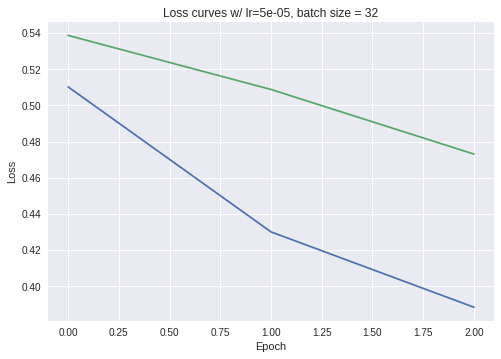

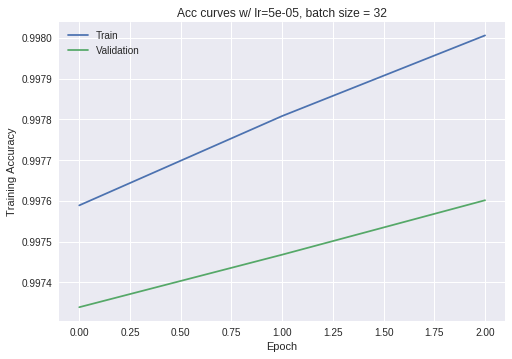

Final Training Accuracy: 0.998006284236908
Final Validation Accuracy: 0.9976017475128174
Finished Training
Total time elapsed: 572.91 seconds


In [315]:
train_net(train_data, valid_data, outputModel)

In [0]:
def get_off_accuracy(model, data_loader):
    p=0
    freq_pos = np.zeros(81)
    freq_neg = np.zeros(80)
    for img, label in data_loader:
        out = model(img)
        out = out.float()
        label = label.cuda()

        for i in range(0,len(label)):
            diff = label[i]+1 - out[i].long()
            if diff>=0:
                freq_pos[diff] +=1
            else:
                freq_neg[diff] +=1

    freq_total = np.concatenate((freq_neg, freq_pos))
    freq_total = freq_total/freq_total.sum()



    diffs = []
    for n in range(-80, 81):
        diffs.append(n)


    plt.bar(diffs[50:110], freq_total[50:110])
    plt.title("Distribution of Actual-Prediction")
    plt.xlabel("difference value")
    plt.ylabel("prob")
    print("+/- 1 years accuracy: {:.2f}%".format(freq_total[79:81].sum()*100))
    print("+/- 5 years accuracy: {:.2f}%".format(freq_total[75:86].sum()*100))
    print("+/- 10 years accuracy: {:.2f}%".format(freq_total[70:91].sum()*100))

+/- 1 years accuracy: 8.61%
+/- 5 years accuracy: 46.90%
+/- 10 years accuracy: 71.59%


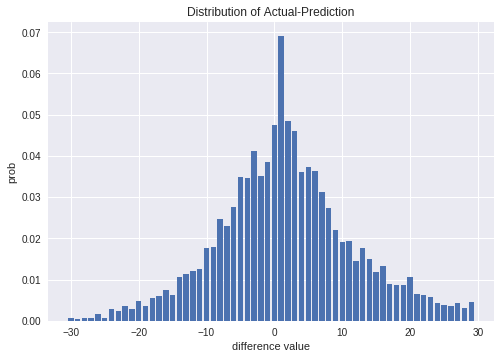

In [317]:
get_off_accuracy(outputModel, valid_data)

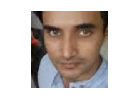

tensor(25) tensor(27.0767, device='cuda:0', grad_fn=<SelectBackward>)


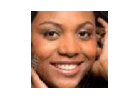

tensor(28) tensor(13.9731, device='cuda:0', grad_fn=<SelectBackward>)


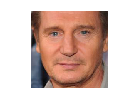

tensor(59) tensor(46.6804, device='cuda:0', grad_fn=<SelectBackward>)


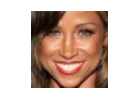

tensor(45) tensor(39.5034, device='cuda:0', grad_fn=<SelectBackward>)


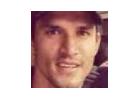

tensor(23) tensor(21.0181, device='cuda:0', grad_fn=<SelectBackward>)


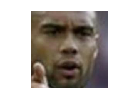

tensor(27) tensor(23.4797, device='cuda:0', grad_fn=<SelectBackward>)


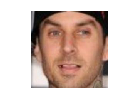

tensor(29) tensor(37.9846, device='cuda:0', grad_fn=<SelectBackward>)


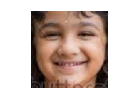

tensor(6) tensor(26.0369, device='cuda:0', grad_fn=<SelectBackward>)


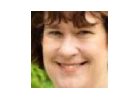

tensor(38) tensor(29.0662, device='cuda:0', grad_fn=<SelectBackward>)


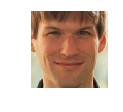

tensor(28) tensor(37.7643, device='cuda:0', grad_fn=<SelectBackward>)


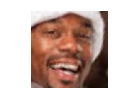

tensor(35) tensor(41.6615, device='cuda:0', grad_fn=<SelectBackward>)


In [307]:
k = 0
for image, label in valid_data:
    img = image[0]
    img = np.transpose(img, [1,2,0])
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.show()
    k += 1
    print(label[0], outputModel(image)[0])
    if k > 10:
        break

In [95]:
print(train_features[0][0][0].shape)
print(train_features[0][0][1])

torch.Size([256, 256, 5, 5])
tensor([ 0, 21, 24, 25, 57, 57, 29,  4, 15, 23, 21, 17, 77, 65, 64,  9, 82,  2,
        31, 51, 24, 25, 22, 28, 81, 21, 35, 27,  0, 34, 13,  0, 30, 41, 99, 40,
         0, 22, 23, 25, 15,  0, 25, 28, 25, 22, 21, 25, 44,  4, 36,  1, 44, 66,
        16, 31, 29, 43, 21, 67, 31, 20, 30,  3, 28, 25, 25, 17, 64, 28, 50, 16,
         0, 57, 57, 45, 41, 53, 31, 34,  1, 25, 19, 54, 31, 25, 35, 35, 25, 26,
        24,  2,  9, 54, 23, 46, 23, 26, 22, 26, 30, 23,  2,  3, 35, 39, 44, 22,
        56,  0, 35,  0, 40, 26,  4, 26, 26, 89, 22, 36, 26, 68, 15, 34,  0, 56,
        89, 41, 23, 27, 42, 44, 25, 42, 49, 26, 25, 56, 32, 39, 83, 53, 44, 25,
        35, 69, 84, 55, 19, 27, 27, 44,  9, 35, 31, 17, 39, 67, 26, 25, 34, 64,
        25, 50,  7, 34, 67, 46, 34, 51, 23, 25, 25, 84, 59, 29, 27, 34, 34, 25,
        52, 39,  3, 27, 34, 53, 29, 25, 46, 23, 47, 65, 25, 55, 79, 17, 21, 55,
        35, 52, 31, 33, 35, 88, 31, 57, 59, 34, 47, 44, 29, 34,  7, 85, 26, 25,
        39,

In [0]:
outputModel = regression()
outputModel = outputModel.cuda()

In [0]:
training_data = []
valid_data = []
test_data = []

for t in features[:518]:
  training_data.append(t)

for t in features[518:629]:
  valid_data.append(t)

for t in features[629:]:
  test_data.append(t)

In [0]:
train_net(train_features, valid_features, outputModel)

Epoch: 1, Training Loss: 14.059, Validation Loss: 9.713, Training Accuracy: 0.387, Validation Accuracy: 0.343
Epoch: 2, Training Loss: 9.296, Validation Loss: 8.820, Training Accuracy: 0.436, Validation Accuracy: 0.388
Epoch: 3, Training Loss: 8.571, Validation Loss: 8.450, Training Accuracy: 0.483, Validation Accuracy: 0.416
Epoch: 4, Training Loss: 8.163, Validation Loss: 8.458, Training Accuracy: 0.496, Validation Accuracy: 0.421
Epoch: 5, Training Loss: 7.786, Validation Loss: 8.213, Training Accuracy: 0.537, Validation Accuracy: 0.454
Epoch: 6, Training Loss: 7.310, Validation Loss: 8.333, Training Accuracy: 0.533, Validation Accuracy: 0.438
Epoch: 7, Training Loss: 7.049, Validation Loss: 7.957, Training Accuracy: 0.580, Validation Accuracy: 0.455
Epoch: 8, Training Loss: 6.808, Validation Loss: 7.943, Training Accuracy: 0.598, Validation Accuracy: 0.471


KeyboardInterrupt: ignored

Epoch: 1, Training Loss: 13.330, Validation Loss: 8.819, Training Accuracy: 0.439, Validation Accuracy: 0.406
Epoch: 2, Training Loss: 8.529, Validation Loss: 8.155, Training Accuracy: 0.510, Validation Accuracy: 0.443
Epoch: 3, Training Loss: 7.821, Validation Loss: 7.911, Training Accuracy: 0.548, Validation Accuracy: 0.457
Epoch: 4, Training Loss: 7.024, Validation Loss: 7.718, Training Accuracy: 0.601, Validation Accuracy: 0.479
Epoch: 5, Training Loss: 6.424, Validation Loss: 7.867, Training Accuracy: 0.629, Validation Accuracy: 0.468
Epoch: 6, Training Loss: 5.865, Validation Loss: 8.394, Training Accuracy: 0.636, Validation Accuracy: 0.442
Epoch: 7, Training Loss: 5.181, Validation Loss: 7.493, Training Accuracy: 0.717, Validation Accuracy: 0.490
Epoch: 8, Training Loss: 4.562, Validation Loss: 7.875, Training Accuracy: 0.743, Validation Accuracy: 0.467
Epoch: 9, Training Loss: 3.883, Validation Loss: 8.568, Training Accuracy: 0.717, Validation Accuracy: 0.413
Epoch: 10, Trainin

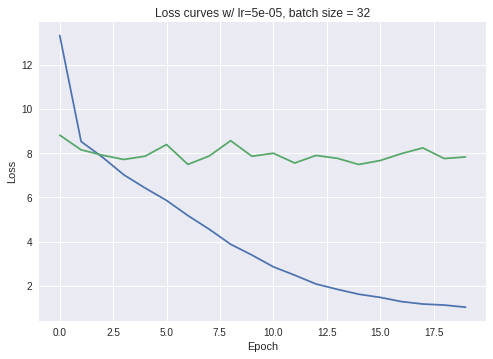

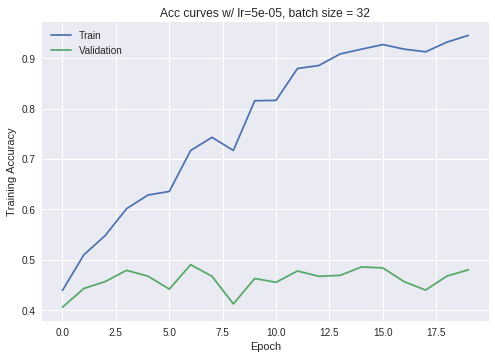

Final Training Accuracy: 0.9452272057533264
Final Validation Accuracy: 0.48007428646087646
Finished Training
Total time elapsed: 674.21 seconds


In [0]:
train_net(training_data, valid_data, outputModel)

Epoch: 1, Training Loss: 14.706, Validation Loss: 9.179, Training Accuracy: 0.401, Validation Accuracy: 0.381
Epoch: 2, Training Loss: 9.091, Validation Loss: 8.829, Training Accuracy: 0.446, Validation Accuracy: 0.394
Epoch: 3, Training Loss: 8.413, Validation Loss: 8.239, Training Accuracy: 0.491, Validation Accuracy: 0.437
Epoch: 4, Training Loss: 7.927, Validation Loss: 8.516, Training Accuracy: 0.493, Validation Accuracy: 0.429
Epoch: 5, Training Loss: 7.606, Validation Loss: 7.981, Training Accuracy: 0.532, Validation Accuracy: 0.455
Epoch: 6, Training Loss: 7.306, Validation Loss: 7.647, Training Accuracy: 0.564, Validation Accuracy: 0.473
Epoch: 7, Training Loss: 6.899, Validation Loss: 7.831, Training Accuracy: 0.570, Validation Accuracy: 0.467
Epoch: 8, Training Loss: 6.688, Validation Loss: 7.614, Training Accuracy: 0.605, Validation Accuracy: 0.475
Epoch: 9, Training Loss: 6.403, Validation Loss: 7.722, Training Accuracy: 0.610, Validation Accuracy: 0.479
Epoch: 10, Trainin

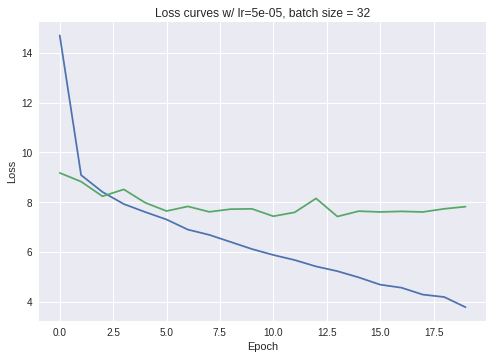

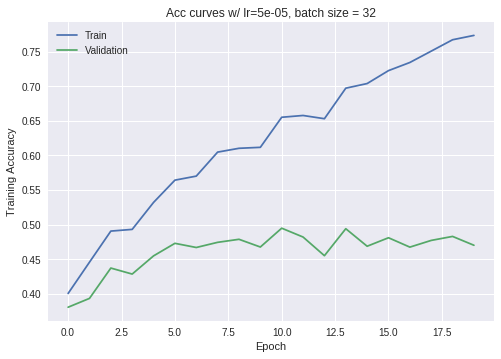

Final Training Accuracy: 0.7735110521316528
Final Validation Accuracy: 0.47028201818466187
Finished Training
Total time elapsed: 268.01 seconds


In [0]:
train_net(training_data, valid_data, outputModel)

In [0]:
0.15*741

111.14999999999999

In [0]:
features[0][0].shape

torch.Size([32])

In [0]:
train_net(train_features, val_features, outputModel)

label: tensor([ 29,  37,  58,  83,  41,  22,  66,  45,   0,  24,  33,  38,  37,  64,
         74,  76,  35,  62, 101,  68,  92,  30,  52,  45,  36,  34,  69,  36,
         35,  95,  44,  40])
output: tensor([[18.4409],
        [19.2436],
        [17.8416],
        [20.9480],
        [15.3228],
        [23.1920],
        [18.1129],
        [18.1491],
        [19.0766],
        [17.3121],
        [18.2097],
        [18.6676],
        [17.1477],
        [15.2325],
        [15.4304],
        [16.0166],
        [12.6306],
        [20.4945],
        [18.0297],
        [18.6420],
        [11.5247],
        [19.9666],
        [16.9993],
        [16.4586],
        [18.4216],
        [17.4677],
        [13.8632],
        [18.1960],
        [22.0543],
        [23.3113],
        [11.6727],
        [18.4347]], grad_fn=<AddmmBackward>)
label: tensor([39,  0, 35, 40, 42, 33, 74, 32, 70, 40, 32, 32, 35, 58, 62, 83, 33, 73,
        86, 57, 56, 31, 26, 45, 59, 37, 38, 42, 72, 42, 35, 46])
output: tensor

KeyboardInterrupt: ignored

In [0]:
train_features = []

for images, labels in train_loader:
  train_features.append((alexNet(images), labels))

val_features = []
for images, labels in valid_loader:
  val_features.append((alexNet(images), labels))
  

'''
count = 0
test_features = []
for images, labels in test_loader:
  test_features.append((alexNet(images), labels))
  count +=1
  if count > 100:
    break
'''

'\ncount = 0\ntest_features = []\nfor images, labels in test_loader:\n  test_features.append((alexNet(images), labels))\n  count +=1\n  if count > 100:\n    break\n'

In [0]:
train_net(train_features, val_features, outputModel)

In [0]:
train_features = []
for images, labels in train_loader:
  train_features.append((vggModel(images), labels))
  break

In [0]:
train_features[0][0].shape

torch.Size([32, 512, 6, 6])

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
vgg16 = models.vgg16()

In [0]:
# vgg16.load_state_dict(torch.load("/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Parameters/vgg_face_dag.pth"))

In [0]:
del vgg16.avgpool
del vgg16.classifier

In [0]:
pre_trained=torch.load("/content/drive/My Drive/APS360_Project_Data/Checkpoints/Model_Parameters/vgg_face_dag.pth")
new=list(pre_trained.items())
# del pre_trained.avgpool
# del pre_trained.classifier
vgg16_key=vgg16.state_dict()
count=0
for key,value in vgg16_key.items():
  if key[0] is 'c':
    continue
  layer_name,weights=new[count]      
  vgg16_key[key]=weights
  count+=1

vgg16.load_state_dict(vgg16_key)

In [0]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
import cv2
image = cv2.imread('/content/drive/My Drive/UTKFace/1_0_0_20161219140623097.jpg.chip.jpg')



In [0]:
img = torch.tensor(image)

In [0]:
img = img.view(1, 200, 200, 3)
print(img.shape)


torch.Size([1, 200, 200, 3])


In [0]:
output = vgg16(img)

RuntimeError: ignored

In [0]:
image = torchvision.transforms.ToTensor()

TypeError: ignored

In [0]:
image

ToTensor()

In [0]:
asd

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
img = torch.from_numpy(image)
print(img.shape)
img = img.permute(2, 0, 1)
print(img.shape)
img = img.view(1, 3, 200, 200)
img = img.type('torch.FloatTensor')

torch.Size([200, 200, 3])
torch.Size([3, 200, 200])


In [0]:
img.shape

torch.Size([1, 3, 200, 200])

In [0]:
JunsModel = VGGfeature()

In [0]:
output = JunsModel(img)

In [0]:
output.shape

torch.Size([1, 512, 6, 6])

In [0]:
Hamssifier = classifier()

In [0]:
output1 = Hamssifier(output)

In [0]:
print(output1)

tensor([[ 7.4779, -0.9297,  6.5836]], grad_fn=<AddmmBackward>)


In [0]:
!pip install PyDrive

    100% |████████████████████████████████| 993kB 20.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
fileId = drive.CreateFile({'id': '0BxYys69jI14kYVM3aVhKS1VhRUk'}) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  # folder_data.zip
fileId.GetContentFile('UTKFace.tar.gz')  # Save Drive file as a local file

UTKFace.tar.gz


In [0]:
!apt-get install p7zip-full
!p7zip -d UTKFace.tar.gz
!tar -xvf UTKFace.tar.gz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
/usr/bin/p7zip: UTKFace.tar.gz: unknown suffix
UTKFace/82_0_2_20170111210110290.jpg.chip.jpg
UTKFace/32_1_2_20170116180211518.jpg.chip.jpg
UTKFace/21_0_4_20170103225103768.jpg.chip.jpg
UTKFace/27_1_2_20170116171716287.jpg.chip.jpg
UTKFace/26_0_4_20170117153355923.jpg.chip.jpg
UTKFace/26_1_0_20170116231512359.jpg.chip.jpg
UTKFace/54_0_3_20170119211308521.jpg.chip.jpg
UTKFace/25_1_1_20170112235005249.jpg.chip.jpg
UTKFace/4_1_2_20161219211452533.jpg.chip.jpg
UTKFace/16_0_0_20170110232647979.jpg.chip.jpg
UTKFace/26_1_0_20170119192623081.jpg.chip.jpg
UTKFace/26_1_1_20170116170028717.jpg.chip.jpg
UTKFace/26_1_2_20170116180214166.jpg.chip.jpg
UTKF

In [0]:
drive = "/content/UTKFace/"
import os

i=0
for i in range(1,117):
  # define the name of the directory to be created
  path = drive + "{}".format(i)

  try:  
      os.mkdir(path)
  except OSError:  
      print ("Creation of the directory %s failed" % path)
  else:  
      print ("Successfully created the directory %s " % path)

Successfully created the directory /content/UTKFace/1 
Successfully created the directory /content/UTKFace/2 
Successfully created the directory /content/UTKFace/3 
Successfully created the directory /content/UTKFace/4 
Successfully created the directory /content/UTKFace/5 
Successfully created the directory /content/UTKFace/6 
Successfully created the directory /content/UTKFace/7 
Successfully created the directory /content/UTKFace/8 
Successfully created the directory /content/UTKFace/9 
Successfully created the directory /content/UTKFace/10 
Successfully created the directory /content/UTKFace/11 
Successfully created the directory /content/UTKFace/12 
Successfully created the directory /content/UTKFace/13 
Successfully created the directory /content/UTKFace/14 
Successfully created the directory /content/UTKFace/15 
Successfully created the directory /content/UTKFace/16 
Successfully created the directory /content/UTKFace/17 
Successfully created the directory /content/UTKFace/18 
S

In [0]:
import shutil
k=0
for root, dirs, files in os.walk(drive): 
   for file in files:
      path_file = os.path.join(root,file)
      age = file.split("_")[0]
      destination = drive + str(age) + "/" + file
      if(file.endswith("jpg")):
        shutil.move(path_file, destination)
        k+=1
        if k%100==0:
          print ("Copying {} to age folder {}".format(file, destination))

Copying 27_1_0_20170116221836595.jpg.chip.jpg to age folder /content/UTKFace/27/27_1_0_20170116221836595.jpg.chip.jpg
Copying 53_1_0_20170110131645457.jpg.chip.jpg to age folder /content/UTKFace/53/53_1_0_20170110131645457.jpg.chip.jpg
Copying 55_0_0_20170117190253859.jpg.chip.jpg to age folder /content/UTKFace/55/55_0_0_20170117190253859.jpg.chip.jpg
Copying 24_1_0_20161223231304660.jpg.chip.jpg to age folder /content/UTKFace/24/24_1_0_20161223231304660.jpg.chip.jpg
Copying 54_0_0_20170120223525741.jpg.chip.jpg to age folder /content/UTKFace/54/54_0_0_20170120223525741.jpg.chip.jpg
Copying 40_0_0_20170117192150908.jpg.chip.jpg to age folder /content/UTKFace/40/40_0_0_20170117192150908.jpg.chip.jpg
Copying 21_0_3_20170119154239873.jpg.chip.jpg to age folder /content/UTKFace/21/21_0_3_20170119154239873.jpg.chip.jpg
Copying 31_1_4_20170117203047078.jpg.chip.jpg to age folder /content/UTKFace/31/31_1_4_20170117203047078.jpg.chip.jpg
Copying 3_1_4_20170103213251308.jpg.chip.jpg to age fold